<a href="https://colab.research.google.com/github/Diego251Fagundes/Data-Science-Machine-Learning-Studies/blob/main/Atividade_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importação

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento e Pipelines
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Métricas de Avaliação
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    precision_recall_curve,
    auc
)


# Instalação do XGBoost

In [ ]:
!pip install xgboost

# 1. Carregar Dataset

In [ ]:
df = sns.load_dataset("titanic")

# Mostrar as primeiras linhas do dataset
print("Shape:", df.shape)
display(df.head())

Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
# Definir a variável alvo
target = 'survived'
features_suggested = ['pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'embarked']

# Selecionar apenas as colunas relevantes
df = df[features_suggested + [target]]

# 1. Separar X e y
X = df.drop(target, axis=1)
y = df[target]

# Dividir para treino e testes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print("\nVerificando valores ausentes no treino:")
print(X_train.isnull().sum())

Formato de X_train: (712, 7)
Formato de X_test: (179, 7)

Verificando valores ausentes no treino:
pclass        0
sex           0
age         137
fare          0
sibsp         0
parch         0
embarked      2
dtype: int64


# 2. Pré Processamento

In [ ]:
# Definir as listas de colunas para cada transformador
numeric_features_scale = ['age', 'fare']

# 'SibSp' e 'Parch' São Numéircas
numeric_features_pass = ['sibsp', 'parch']

# 'Sex', 'Embarked' e 'Pclass' são categóricas
categorical_features = ['sex', 'embarked', 'pclass']

# Pipeline para features numéricas que precisam de scaling
numeric_transformer_scale = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para features numéricas que NÃO precisam de scaling
numeric_transformer_pass = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline para features categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [ ]:
# Combinar os pipelines usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scale', numeric_transformer_scale, numeric_features_scale),
        ('num_pass', numeric_transformer_pass, numeric_features_pass),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Descarta colunas não especificadas
)

In [ ]:
# Teste do pré Processador
X_train_processed = preprocessor.fit_transform(X_train)
print(f"\nFormato dos dados após pré-processamento: {X_train_processed.shape}")


Formato dos dados após pré-processamento: (712, 12)


# 3. Modelagem

In [ ]:
# Definir a estratégia de validação cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir os modelos e seus pipelines completos
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='rbf', probability=True, random_state=42))
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False))
])


# Definir os grids de hiperparâmetros para RamdomizedSearchCV
param_dist_rf = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

param_dist_svm = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': ['scale', 'auto', 0.01, 0.1, 1],
}

param_dist_xgb = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 9],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Agrupar os modelos e parâmetros
model_search_config = {
    'RandomForest': (pipeline_rf, param_dist_rf),
    'SVM (RBF)': (pipeline_svm, param_dist_svm),
    'XGBoost': (pipeline_xgb, param_dist_xgb),
}

# Dicionário para armazenar os resultados
results = {}
best_estimators = {}

In [ ]:
# Treinamento e Otimização dos modelos

# Número de iterações para a busca aleatória
N_ITER_SEARCH = 20

for model_name, (pipeline, param_dist) in model_search_config.items():
    print(f"--- Iniciando Otimização para: {model_name} ---")

    # Configurar o RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=N_ITER_SEARCH,
        scoring='roc_auc',
        cv=cv_strategy,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Treinar o modelo
    random_search.fit(X_train, y_train)

    # Salvar o melhor modelo
    best_estimators[model_name] = random_search.best_estimator_

    print(f"Melhor ROC-AUC (CV): {random_search.best_score_:.4f}")
    print(f"Melhores parâmetros: {random_search.best_params_}\n")

--- Iniciando Otimização para: RandomForest ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhor ROC-AUC (CV): 0.8806
Melhores parâmetros: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None}

--- Iniciando Otimização para: SVM (RBF) ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhor ROC-AUC (CV): 0.8599
Melhores parâmetros: {'model__gamma': 0.01, 'model__C': 1}

--- Iniciando Otimização para: XGBoost ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhor ROC-AUC (CV): 0.8849
Melhores parâmetros: {'model__subsample': 0.9, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}



# 4. Métricas

In [ ]:
# Dicionário para armazenar as métricas de teste
test_metrics = {}

for model_name, model in best_estimators.items():

    # Fazer previsões
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Armazenar métricas
    test_metrics[model_name] = {
        'Acurácia': accuracy,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Matriz de Confusão': cm
    }

    # Imprimir relatório de classificação
    print(f"--- Relatório de Classificação: {model_name} ---")
    print(classification_report(y_test, y_pred))
    print("-" * 50 + "\n")

# Criar a tabela comparativa
metrics_df = pd.DataFrame(test_metrics).T.drop(columns=['Matriz de Confusão'])
print("--- Tabela Comparativa de Métricas (Dados de Teste) ---")
display(metrics_df.sort_values(by='ROC-AUC', ascending=False))

--- Relatório de Classificação: RandomForest ---
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       110
           1       0.82      0.65      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179

--------------------------------------------------

--- Relatório de Classificação: SVM (RBF) ---
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       110
           1       0.75      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179

--------------------------------------------------

--- Relatório de Classificação: XGBoost ---
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     

,Acurácia,F1-Score,ROC-AUC
SVM (RBF),0.787709,0.707692,0.846772
RandomForest,0.810056,0.725806,0.83834
XGBoost,0.793296,0.699187,0.809881


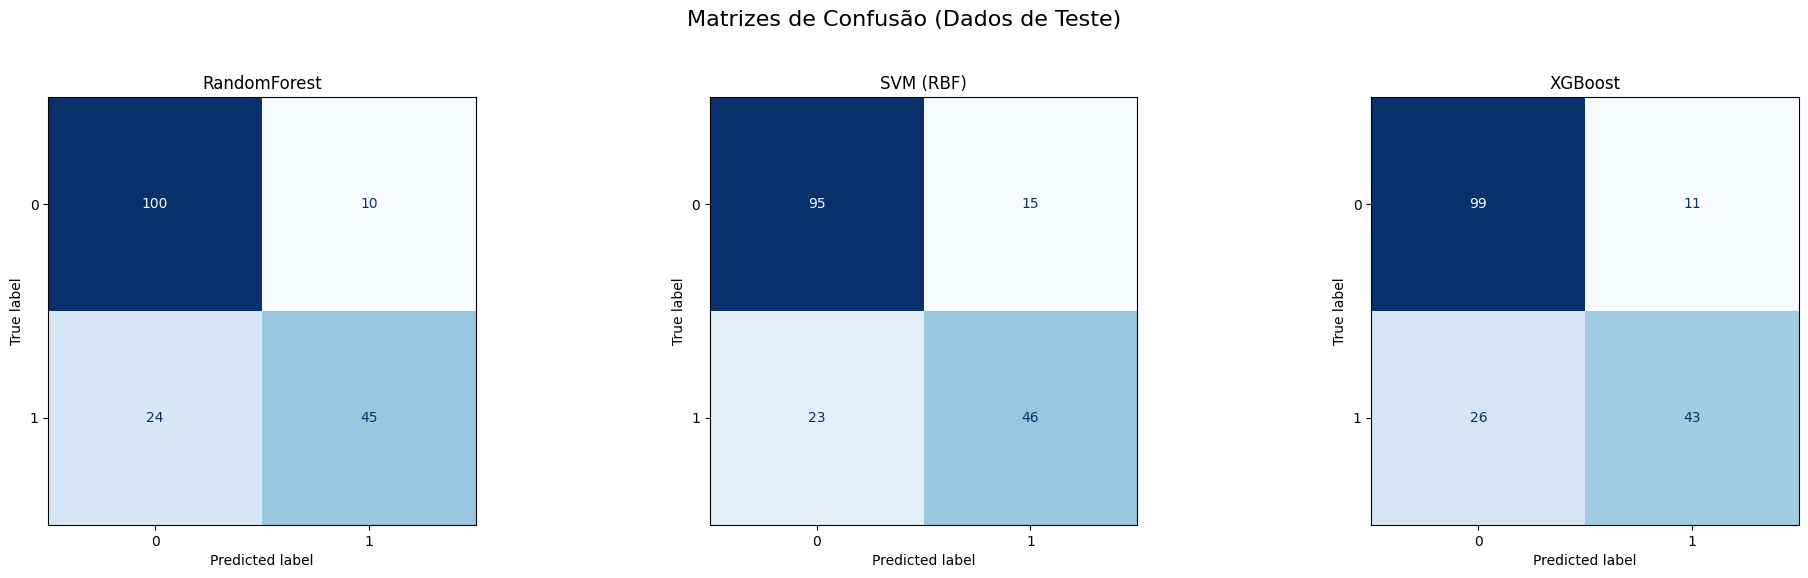

In [ ]:
# Matriz de confusão de cada modelo
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Matrizes de Confusão (Dados de Teste)', fontsize=16)

for ax, (model_name, metrics) in zip(axes.flatten(), test_metrics.items()):
    cm = metrics['Matriz de Confusão']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(model_name)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

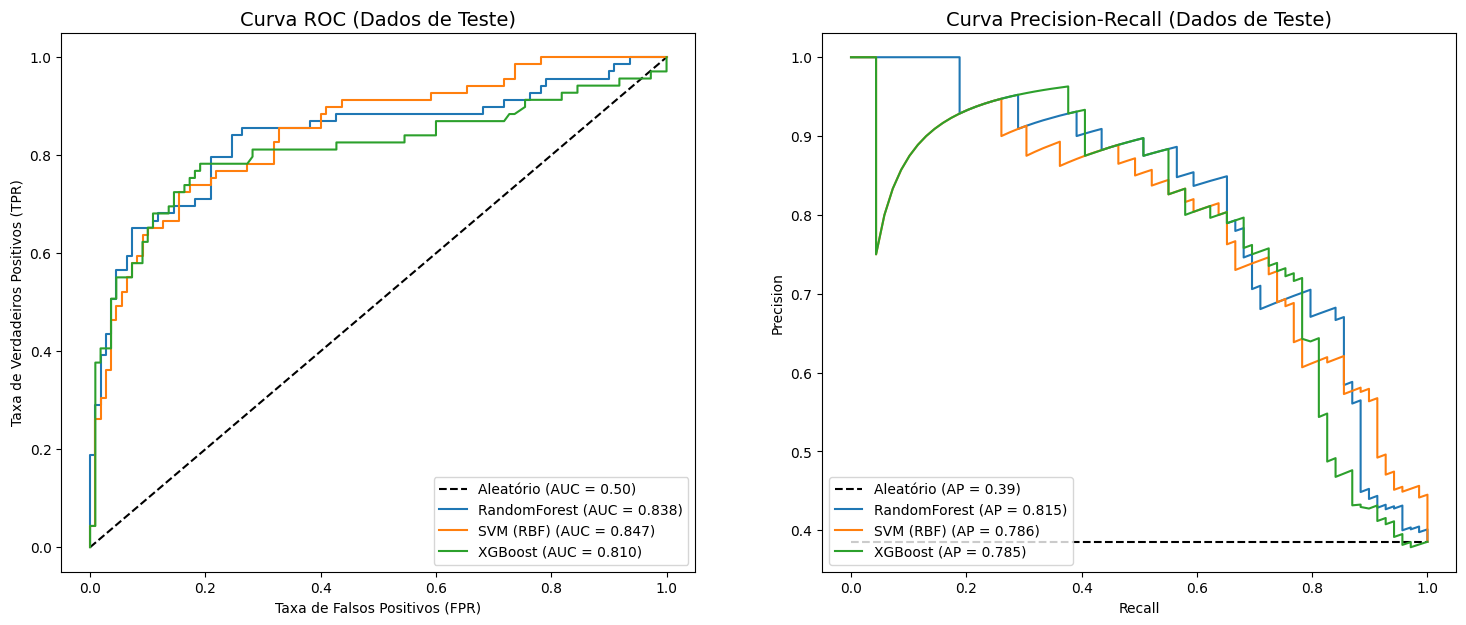

In [ ]:
# Configurar os plots
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(18, 7))

# Plot da Curva ROC
ax_roc.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')
ax_roc.set_title('Curva ROC (Dados de Teste)', fontsize=14)
ax_roc.set_xlabel('Taxa de Falsos Positivos (FPR)')
ax_roc.set_ylabel('Taxa de Verdadeiros Positivos (TPR)')

# Plot da Curva Precision-Recall
no_skill = len(y_test[y_test==1]) / len(y_test)
ax_pr.plot([0, 1], [no_skill, no_skill], 'k--', label=f'Aleatório (AP = {no_skill:.2f})')
ax_pr.set_title('Curva Precision-Recall (Dados de Teste)', fontsize=14)
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')

# Calcular e plotar as curvas para cada modelo
for model_name, model in best_estimators.items():
    y_proba = model.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision) # Note a ordem: auc(recall, precision)
    ax_pr.plot(recall, precision, label=f'{model_name} (AP = {pr_auc:.3f})')

ax_roc.legend(loc='lower right')
ax_pr.legend(loc='lower left')
plt.show()

# 5. Resultados Esperados

# Discussão

1) Qual modelo apresentou melhor desempenho?

**R: ** O SVM (RBF) apresentou o melhor desempenho em termos de ROC-AUC com 0.846772.

No precision recall o Random Forest foi superior com um Average PRecision (AP) de 0.815

2) Algum modelo mostrou sinais de overfitting?

**R:** Sim, dois modelos mostraram sinais claros de overfitting, sendo um deles mais acentuado:
* XGBoost: Foi o modelo que apresentou o overfitting mais significativo. Ele obteve o melhor desempenho durante a validação cruzada (CV) com um ROC-AUC de 0.8849, mas sofreu a maior queda de performance ao ser aplicado nos dados de teste, caindo para 0.8099 (uma diferença de -0.075). Isso indica que o modelo se ajustou excessivamente aos dados de treino e não generalizou tão bem para dados novos.
* RandomForest: Também mostrou sinais de overfitting, mas de forma mais branda que o XGBoost. Ele teve um score de 0.8806 no treino (CV) e caiu para 0.8383 no teste (uma diferença de -0.042).

3) Quais foram as dificuldades no pré-processamento?

**R: ** As principais dificuldades no pré-processamento foram:
 Valores ausentes pois a coluna "Age" tinha muitos com mais de 100 ausentes;

 Tratamento de variaveis pois Age e Fare são continuas e tem escalas muito diferentes;

 Codificação Categórica: A variável Pclass é numerica, mas representa uma categoria ordinal. No entanto, tratá-la como nominal usando OneHotEncoder é uma abordagem segura.